In [1]:
from expelliarmus import Wizard
import pathlib
import h5py
import numpy as np
import timeit
import requests

FIRST_RUN = True
REPEAT = 5

In [2]:
def get_diff_perc(ref, val):
    if val > ref:
        return ((val - ref) / ref) * 100
    else:
        return -((ref - val) / val) * 100


def get_diff_perc_str(ref, val):
    if val > ref:
        return f"+{((val-ref)/ref)*100:.2f}%"
    else:
        return f"-{((ref-val)/val)*100:.2f}%"


get_fsize_MB = lambda fpath: round(fpath.stat().st_size / (1024 * 1024))

In [3]:
if FIRST_RUN:
    # Downloading files.
    if not pathlib.Path("./spinner.dat").is_file():
        print("Downloading DAT file...")
        r = requests.get(
            "https://dataset.prophesee.ai/index.php/s/YAri3vpPZHhEZfc/download",
            allow_redirects=True,
        )  # spinner.dat, DAT
        open("./spinner.dat", "wb").write(r.content)
    if not pathlib.Path("./monitoring_40_50hz.raw").is_file():
        print("Downloading EVT2 file...")
        r = requests.get(
            "https://dataset.prophesee.ai/index.php/s/s5DFqzVQhlaU8Y5/download",
            allow_redirects=True,
        )  # monitoring_40_50hz.raw, EVT2
        open("./monitoring_40_50hz.raw", "wb").write(r.content)
    if not pathlib.Path("./driving_sample.raw").is_file():
        print("Downloading EVT3 file...")
        r = requests.get(
            "https://dataset.prophesee.ai/index.php/s/nVcLLdWAnNzrmII/download",
            allow_redirects=True,
        )  # driving_sample.raw, EVT3
        open("./driving_sample.raw", "wb").write(r.content)
    print("Everything downloaded!")

Everything downloaded!


In [4]:
files = ("spinner.dat", "monitoring_40_50hz.raw", "driving_sample.raw")
encodings = ("dat", "evt2", "evt3")
wizard = Wizard(encoding="dat")

softwares = ("expelliarmus", "hdf5", "hdf5_lzf", "hdf5_gzip", "numpy")
encodings = ("dat", "evt2", "evt3")
metrics = ("fsize", "full_read", "chunk_read")
data = {}
for software in softwares:
    data[software] = {}
    for encoding in encodings:
        data[software][encoding] = {}
        for metric in metrics:
            data[software][encoding][metric] = 0

In [5]:
print("=" * 50 + "\nFull file read")
for f, encoding in zip(files, encodings):
    print("=" * 50)
    wizard.set_encoding(encoding)
    exp_fpath = pathlib.Path(f)
    hdf5_fpath = pathlib.Path(f"./ref_HDF5_{encoding.upper()}.hdf5")
    hdf5_lzf_fpath = pathlib.Path(f"./ref_HDF5_LZF_{encoding.upper()}.hdf5")
    hdf5_gzip_fpath = pathlib.Path(f"./ref_HDF5_GZIP_{encoding.upper()}.hdf5")
    np_fpath = pathlib.Path(f"./ref_np_{encoding.upper()}.npy")

    arr = wizard.read(exp_fpath)
    data["expelliarmus"][encoding]["fsize"] = get_fsize_MB(exp_fpath)

    # HDF5
    if FIRST_RUN:
        hdf5_fp = h5py.File(hdf5_fpath, "w")
        arr_hdf5 = hdf5_fp.create_dataset("arr", arr.shape, arr.dtype)
        arr_hdf5[:] = arr[:]
        hdf5_fp.close()
    data["hdf5"][encoding]["fsize"] = get_fsize_MB(hdf5_fpath)

    # HDF5 LZF
    if FIRST_RUN:
        hdf5_lzf_fp = h5py.File(hdf5_lzf_fpath, "w")
        arr_hdf5_lzf = hdf5_lzf_fp.create_dataset(
            "arr", arr.shape, arr.dtype, compression="lzf"
        )
        arr_hdf5_lzf[:] = arr[:]
        hdf5_lzf_fp.close()
    data["hdf5_lzf"][encoding]["fsize"] = get_fsize_MB(hdf5_lzf_fpath)

    # HDF5 GZIP
    if FIRST_RUN:
        hdf5_gzip_fp = h5py.File(hdf5_gzip_fpath, "w")
        arr_hdf5_gzip = hdf5_gzip_fp.create_dataset(
            "arr", arr.shape, arr.dtype, compression="gzip"
        )
        arr_hdf5_gzip[:] = arr[:]
        hdf5_gzip_fp.close()
    data["hdf5_gzip"][encoding]["fsize"] = get_fsize_MB(hdf5_gzip_fpath)

    # NumPy
    if FIRST_RUN:
        np.save(np_fpath, arr, allow_pickle=False)
    data["numpy"][encoding]["fsize"] = get_fsize_MB(np_fpath)

    data["expelliarmus"][encoding]["full_read"] = (
        sum(timeit.repeat(lambda: wizard.read(exp_fpath), number=1, repeat=REPEAT))
        / REPEAT
    )
    print(
        f'{encoding.upper()} ({data["expelliarmus"][encoding]["fsize"]}MB) avg_time = {data["expelliarmus"][encoding]["full_read"]:.3f}s.'
    )

    hdf5_fp = h5py.File(hdf5_fpath)
    data["hdf5"][encoding]["full_read"] = (
        sum(timeit.repeat(lambda: hdf5_fp["arr"][:], number=1, repeat=REPEAT)) / REPEAT
    )
    print(
        f'HDF5 ({data["hdf5"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5"][encoding]["fsize"])}) avg_time = {data["hdf5"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5"][encoding]["full_read"])}.'
    )
    hdf5_fp.close()

    hdf5_LZF_fp = h5py.File(hdf5_lzf_fpath)
    data["hdf5_lzf"][encoding]["full_read"] = (
        sum(timeit.repeat(lambda: hdf5_LZF_fp["arr"][:], number=1, repeat=REPEAT))
        / REPEAT
    )
    print(
        f'HDF5 LZF ({data["hdf5_lzf"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_lzf"][encoding]["fsize"])}) avg_time = {data["hdf5_lzf"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5_lzf"][encoding]["full_read"])}.'
    )
    hdf5_LZF_fp.close()

    hdf5_GZIP_fp = h5py.File(hdf5_gzip_fpath)
    data["hdf5_gzip"][encoding]["full_read"] = (
        sum(timeit.repeat(lambda: hdf5_GZIP_fp["arr"][:], number=1, repeat=REPEAT))
        / REPEAT
    )
    print(
        f'HDF5 GZIP ({data["hdf5_gzip"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_gzip"][encoding]["fsize"])}) avg_time = {data["hdf5_gzip"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5_gzip"][encoding]["full_read"])}.'
    )
    hdf5_GZIP_fp.close()

    data["numpy"][encoding]["full_read"] = (
        sum(timeit.repeat(lambda: np.load(np_fpath), number=1, repeat=REPEAT)) / REPEAT
    )
    print(
        f'NumPy ({data["numpy"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["numpy"][encoding]["fsize"])}) avg_time = {data["numpy"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["numpy"][encoding]["full_read"])}.'
    )

Full file read
DAT (413MB) avg_time = 0.706s.
HDF5 (826MB, +100.00%) avg_time = 0.472s, -49.65%.
HDF5 LZF (316MB, -30.70%) avg_time = 1.924s, +172.50%.
HDF5 GZIP (163MB, -153.37%) avg_time = 3.178s, +350.05%.
NumPy (826MB, +100.00%) avg_time = 0.893s, +26.48%.
EVT2 (157MB) avg_time = 0.589s.
HDF5 (621MB, +295.54%) avg_time = 0.373s, -58.05%.
HDF5 LZF (276MB, +75.80%) avg_time = 1.631s, +176.65%.
HDF5 GZIP (156MB, -0.64%) avg_time = 2.737s, +364.30%.
NumPy (621MB, +295.54%) avg_time = 0.407s, -44.66%.
EVT3 (350MB) avg_time = 3.185s.
HDF5 (1701MB, +386.00%) avg_time = 1.579s, -101.72%.
HDF5 LZF (746MB, +113.14%) avg_time = 4.507s, +41.49%.
HDF5 GZIP (419MB, +19.71%) avg_time = 7.715s, +142.23%.
NumPy (1701MB, +386.00%) avg_time = 2.396s, -32.92%.


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use("classic")
%matplotlib inline

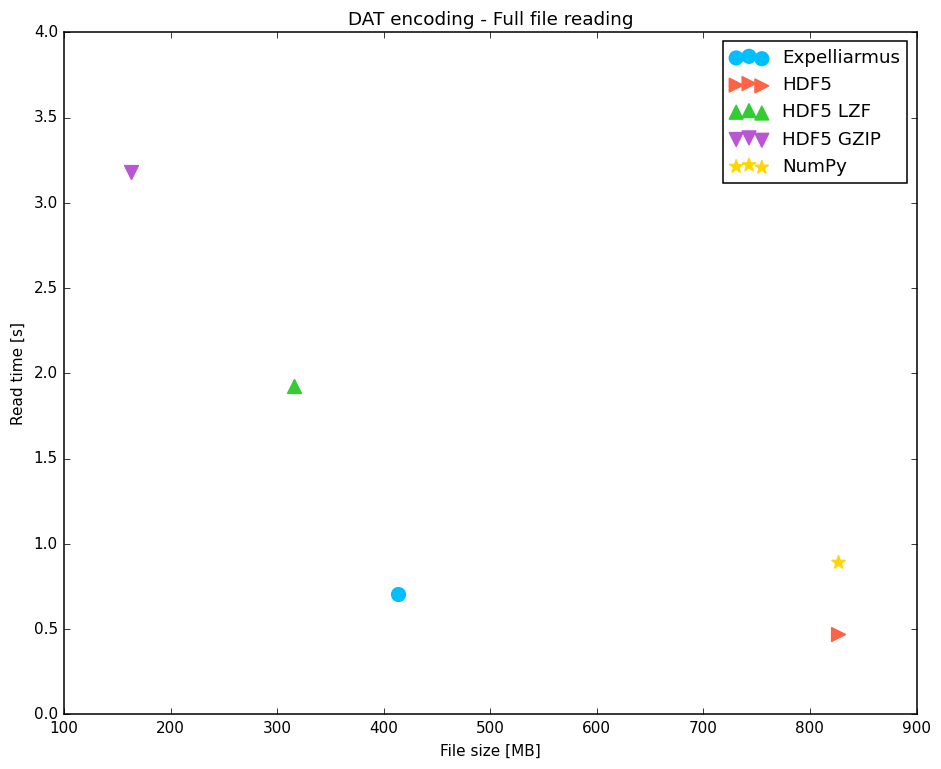

In [7]:
plt.figure(figsize=(10, 8), dpi=110)
plt.ylim(bottom=0, top=4)
plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("DAT encoding - Full file reading")

# Expelliarmus
exp = plt.scatter(
    data["expelliarmus"]["dat"]["fsize"],
    data["expelliarmus"]["dat"]["full_read"],
    marker="o",
    s=80,
    color="deepskyblue",
)

# HDF5
hdf5 = plt.scatter(
    data["hdf5"]["dat"]["fsize"],
    data["hdf5"]["dat"]["full_read"],
    marker=">",
    s=80,
    color="tomato",
)

# HDF5 LZF
hdf5_lzf = plt.scatter(
    data["hdf5_lzf"]["dat"]["fsize"],
    data["hdf5_lzf"]["dat"]["full_read"],
    marker="^",
    s=80,
    color="limegreen",
)

# HDF5 GZIP
hdf5_gzip = plt.scatter(
    data["hdf5_gzip"]["dat"]["fsize"],
    data["hdf5_gzip"]["dat"]["full_read"],
    marker="v",
    s=80,
    color="mediumorchid",
)

# NumPy
npy = plt.scatter(
    data["numpy"]["dat"]["fsize"],
    data["numpy"]["dat"]["full_read"],
    marker="*",
    s=80,
    color="gold",
)

plt.legend(
    (exp, hdf5, hdf5_lzf, hdf5_gzip, npy),
    ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP", "NumPy"),
    loc="upper right",
)
plt.show()

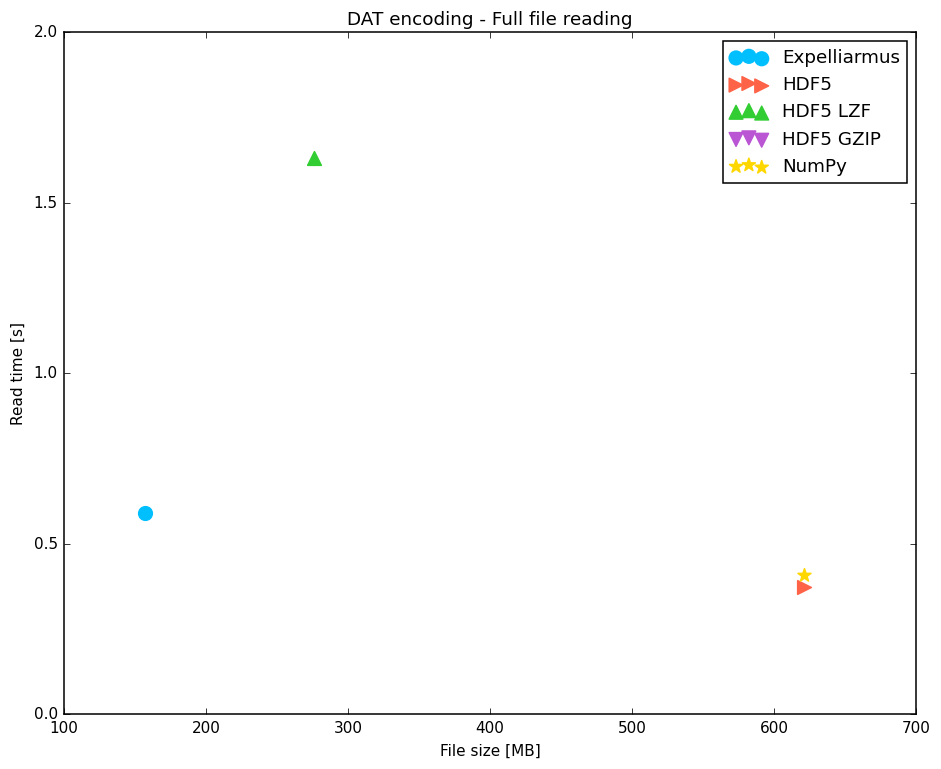

In [8]:
plt.figure(figsize=(10, 8), dpi=110)
plt.ylim(bottom=0, top=2)
plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("DAT encoding - Full file reading")

# Expelliarmus
exp = plt.scatter(
    data["expelliarmus"]["evt2"]["fsize"],
    data["expelliarmus"]["evt2"]["full_read"],
    marker="o",
    s=80,
    color="deepskyblue",
)

# HDF5
hdf5 = plt.scatter(
    data["hdf5"]["evt2"]["fsize"],
    data["hdf5"]["evt2"]["full_read"],
    marker=">",
    s=80,
    color="tomato",
)

# HDF5 LZF
hdf5_lzf = plt.scatter(
    data["hdf5_lzf"]["evt2"]["fsize"],
    data["hdf5_lzf"]["evt2"]["full_read"],
    marker="^",
    s=80,
    color="limegreen",
)

# HDF5 GZIP
hdf5_gzip = plt.scatter(
    data["hdf5_gzip"]["evt2"]["fsize"],
    data["hdf5_gzip"]["evt2"]["full_read"],
    marker="v",
    s=80,
    color="mediumorchid",
)

# NumPy
npy = plt.scatter(
    data["numpy"]["evt2"]["fsize"],
    data["numpy"]["evt2"]["full_read"],
    marker="*",
    s=80,
    color="gold",
)

plt.legend(
    (exp, hdf5, hdf5_lzf, hdf5_gzip, npy),
    ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP", "NumPy"),
    loc="upper right",
)
plt.show()

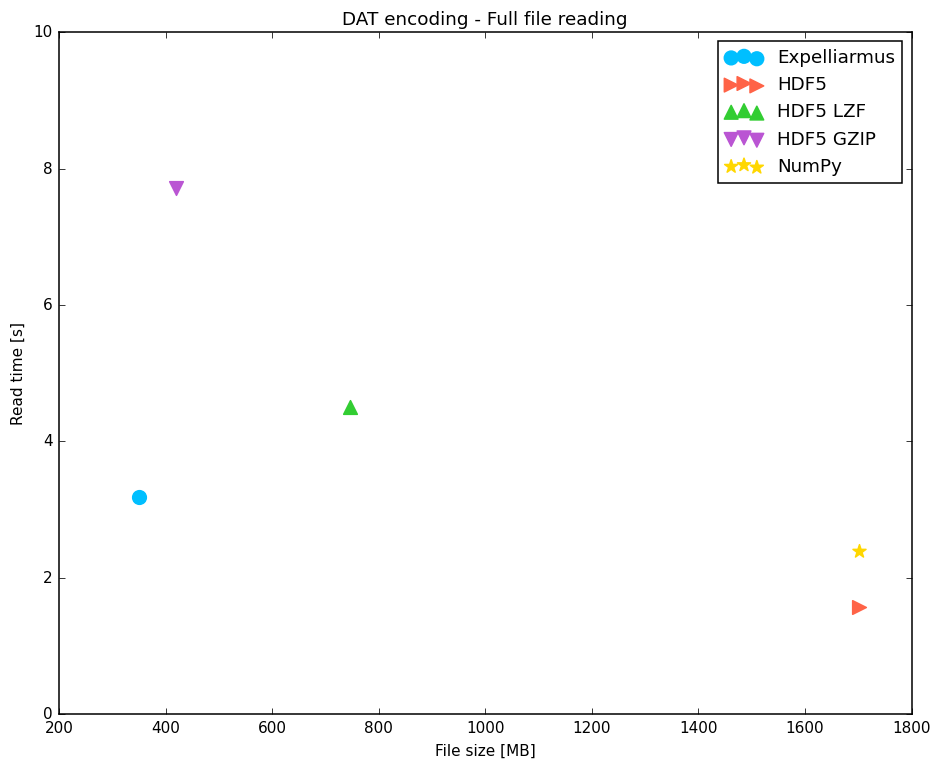

In [9]:
plt.figure(figsize=(10, 8), dpi=110)
plt.ylim(bottom=0, top=10)
plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("DAT encoding - Full file reading")

# Expelliarmus
exp = plt.scatter(
    data["expelliarmus"]["evt3"]["fsize"],
    data["expelliarmus"]["evt3"]["full_read"],
    marker="o",
    s=80,
    color="deepskyblue",
)

# HDF5
hdf5 = plt.scatter(
    data["hdf5"]["evt3"]["fsize"],
    data["hdf5"]["evt3"]["full_read"],
    marker=">",
    s=80,
    color="tomato",
)

# HDF5 LZF
hdf5_lzf = plt.scatter(
    data["hdf5_lzf"]["evt3"]["fsize"],
    data["hdf5_lzf"]["evt3"]["full_read"],
    marker="^",
    s=80,
    color="limegreen",
)

# HDF5 GZIP
hdf5_gzip = plt.scatter(
    data["hdf5_gzip"]["evt3"]["fsize"],
    data["hdf5_gzip"]["evt3"]["full_read"],
    marker="v",
    s=80,
    color="mediumorchid",
)

# NumPy
npy = plt.scatter(
    data["numpy"]["evt3"]["fsize"],
    data["numpy"]["evt3"]["full_read"],
    marker="*",
    s=80,
    color="gold",
)

plt.legend(
    (exp, hdf5, hdf5_lzf, hdf5_gzip, npy),
    ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP", "NumPy"),
    loc="upper right",
)
plt.show()

In [10]:
CHUNK_SIZE = 8192
print("\n" + "=" * 50 + "\nChunk reading.")
for f, encoding in zip(files, encodings):
    print("=" * 50)

    arr_len = len(np.load(f"ref_np_{encoding.upper()}.npy"))
    exp_fpath = pathlib.Path(f)
    hdf5_fpath = pathlib.Path(f"./ref_HDF5_{encoding.upper()}.hdf5")
    hdf5_lzf_fpath = pathlib.Path(f"./ref_HDF5_LZF_{encoding.upper()}.hdf5")
    hdf5_gzip_fpath = pathlib.Path(f"./ref_HDF5_GZIP_{encoding.upper()}.hdf5")

    wizard.set_encoding(encoding)

    def fn():
        wizard.setup_chunk(exp_fpath, CHUNK_SIZE)
        return [chunk for chunk in wizard.read_chunk()]

    data["expelliarmus"][encoding]["chunk_read"] = (
        sum(timeit.repeat(fn, number=1, repeat=REPEAT)) / REPEAT
    )
    print(
        f'{encoding.upper()} ({data["expelliarmus"][encoding]["fsize"]}MB) avg_time = {data["expelliarmus"][encoding]["chunk_read"]:.3f}s.'
    )

    hdf5_fp = h5py.File(hdf5_fpath)
    data["hdf5"][encoding]["chunk_read"] = (
        sum(
            timeit.repeat(
                lambda: [
                    hdf5_fp["arr"][i * CHUNK_SIZE : min(arr_len, (i + 1) * CHUNK_SIZE)]
                    for i in range(arr_len // CHUNK_SIZE)
                ],
                number=1,
                repeat=REPEAT,
            )
        )
        / REPEAT
    )
    print(
        f'HDF5 ({data["hdf5"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5"][encoding]["fsize"])}) avg_time = {data["hdf5"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5"][encoding]["chunk_read"])}.'
    )

    hdf5_lzf_fp = h5py.File(hdf5_lzf_fpath)
    data["hdf5_lzf"][encoding]["chunk_read"] = (
        sum(
            timeit.repeat(
                lambda: [
                    hdf5_lzf_fp["arr"][
                        i * CHUNK_SIZE : min(arr_len, (i + 1) * CHUNK_SIZE)
                    ]
                    for i in range(arr_len // CHUNK_SIZE)
                ],
                number=1,
                repeat=REPEAT,
            )
        )
        / REPEAT
    )
    print(
        f'HDF5 LZF ({data["hdf5_lzf"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_lzf"][encoding]["fsize"])}) avg_time = {data["hdf5_lzf"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5_lzf"][encoding]["chunk_read"])}.'
    )

    hdf5_gzip_fp = h5py.File(hdf5_gzip_fpath)
    data["hdf5_gzip"][encoding]["chunk_read"] = (
        sum(
            timeit.repeat(
                lambda: [
                    hdf5_gzip_fp["arr"][
                        i * CHUNK_SIZE : min(arr_len, (i + 1) * CHUNK_SIZE)
                    ]
                    for i in range(arr_len // CHUNK_SIZE)
                ],
                number=1,
                repeat=REPEAT,
            )
        )
        / REPEAT
    )
    print(
        f'HDF5 GZIP ({data["hdf5_gzip"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_gzip"][encoding]["fsize"])}) avg_time = {data["hdf5_gzip"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5_lzf"][encoding]["chunk_read"])}.'
    )

    hdf5_fp.close()
    hdf5_lzf_fp.close()
    hdf5_gzip_fp.close()


Chunk reading.
DAT (413MB) avg_time = 1.299s.
HDF5 (826MB, +100.00%) avg_time = 3.503s, +169.74%.
HDF5 LZF (316MB, -30.70%) avg_time = 5.654s, +335.39%.
HDF5 GZIP (163MB, -153.37%) avg_time = 7.641s, +335.39%.
EVT2 (157MB) avg_time = 0.510s.
HDF5 (621MB, +295.54%) avg_time = 2.153s, +321.92%.
HDF5 LZF (276MB, +75.80%) avg_time = 5.072s, +893.96%.
HDF5 GZIP (156MB, -0.64%) avg_time = 7.536s, +893.96%.
EVT3 (350MB) avg_time = 2.649s.
HDF5 (1701MB, +386.00%) avg_time = 6.756s, +155.04%.
HDF5 LZF (746MB, +113.14%) avg_time = 14.561s, +449.73%.
HDF5 GZIP (419MB, +19.71%) avg_time = 23.323s, +449.73%.


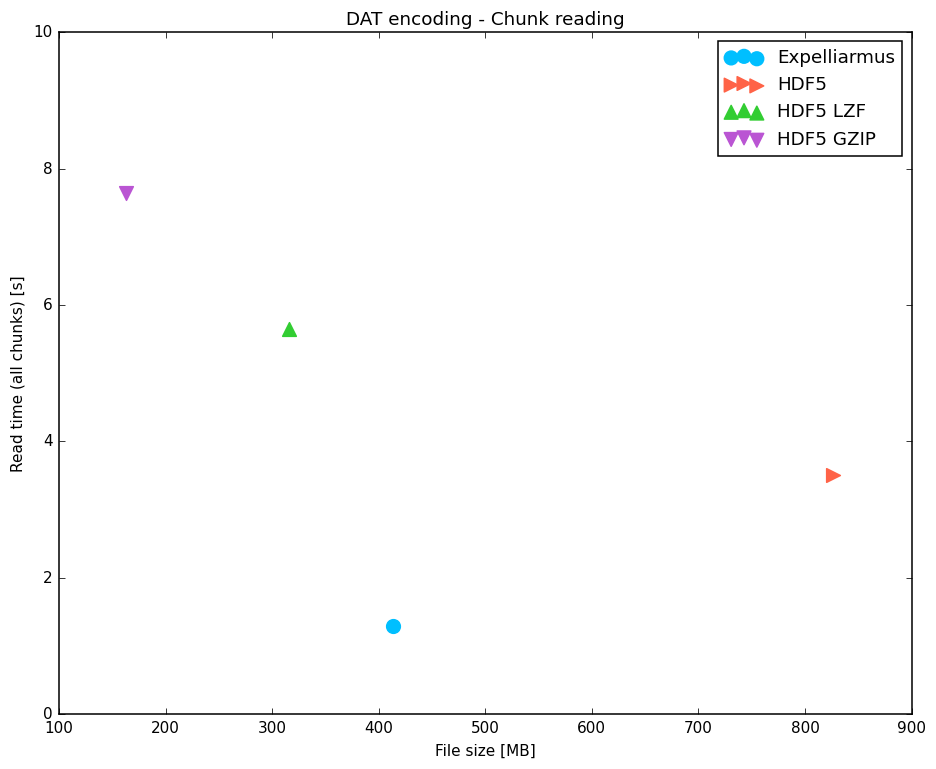

In [11]:
plt.figure(figsize=(10, 8), dpi=110)
plt.ylim(bottom=0, top=10)
plt.xlabel("File size [MB]")
plt.ylabel("Read time (all chunks) [s]")
plt.title("DAT encoding - Chunk reading")

# Expelliarmus
exp = plt.scatter(
    data["expelliarmus"]["dat"]["fsize"],
    data["expelliarmus"]["dat"]["chunk_read"],
    marker="o",
    s=80,
    color="deepskyblue",
)

# HDF5
hdf5 = plt.scatter(
    data["hdf5"]["dat"]["fsize"],
    data["hdf5"]["dat"]["chunk_read"],
    marker=">",
    s=80,
    color="tomato",
)

# HDF5 LZF
hdf5_lzf = plt.scatter(
    data["hdf5_lzf"]["dat"]["fsize"],
    data["hdf5_lzf"]["dat"]["chunk_read"],
    marker="^",
    s=80,
    color="limegreen",
)

# HDF5 GZIP
hdf5_gzip = plt.scatter(
    data["hdf5_gzip"]["dat"]["fsize"],
    data["hdf5_gzip"]["dat"]["chunk_read"],
    marker="v",
    s=80,
    color="mediumorchid",
)

plt.legend(
    (exp, hdf5, hdf5_lzf, hdf5_gzip),
    ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP"),
    loc="upper right",
)
plt.show()

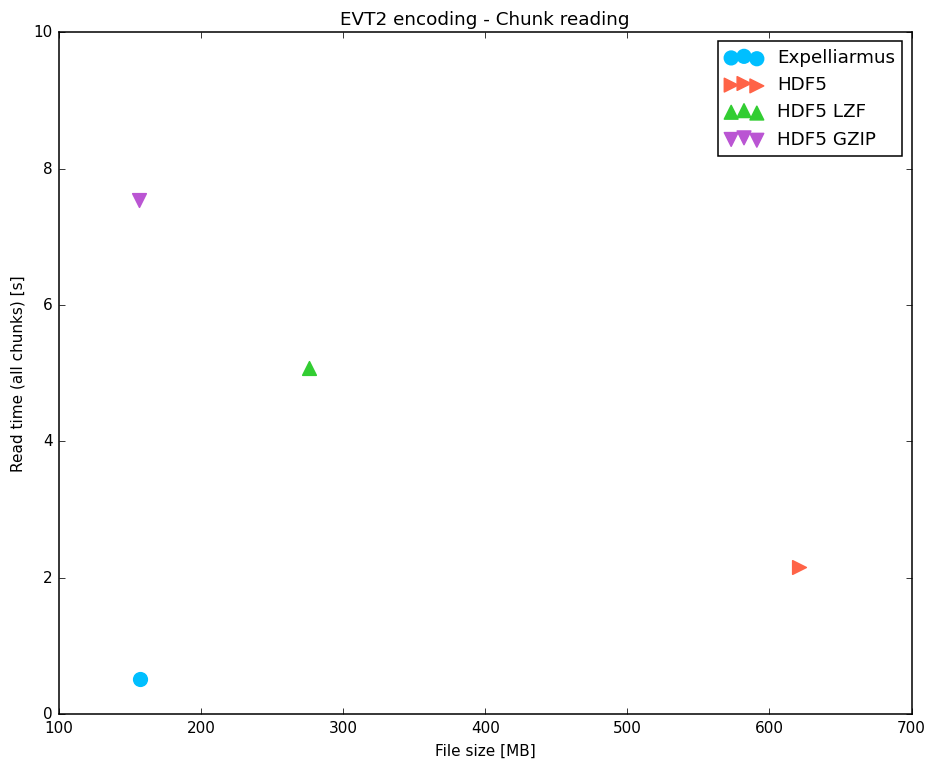

In [12]:
plt.figure(figsize=(10, 8), dpi=110)
plt.ylim(bottom=0, top=10)
plt.xlabel("File size [MB]")
plt.ylabel("Read time (all chunks) [s]")
plt.title("EVT2 encoding - Chunk reading")

# Expelliarmus
exp = plt.scatter(
    data["expelliarmus"]["evt2"]["fsize"],
    data["expelliarmus"]["evt2"]["chunk_read"],
    marker="o",
    s=80,
    color="deepskyblue",
)

# HDF5
hdf5 = plt.scatter(
    data["hdf5"]["evt2"]["fsize"],
    data["hdf5"]["evt2"]["chunk_read"],
    marker=">",
    s=80,
    color="tomato",
)

# HDF5 LZF
hdf5_lzf = plt.scatter(
    data["hdf5_lzf"]["evt2"]["fsize"],
    data["hdf5_lzf"]["evt2"]["chunk_read"],
    marker="^",
    s=80,
    color="limegreen",
)

# HDF5 GZIP
hdf5_gzip = plt.scatter(
    data["hdf5_gzip"]["evt2"]["fsize"],
    data["hdf5_gzip"]["evt2"]["chunk_read"],
    marker="v",
    s=80,
    color="mediumorchid",
)

plt.legend(
    (exp, hdf5, hdf5_lzf, hdf5_gzip),
    ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP"),
    loc="upper right",
)
plt.show()

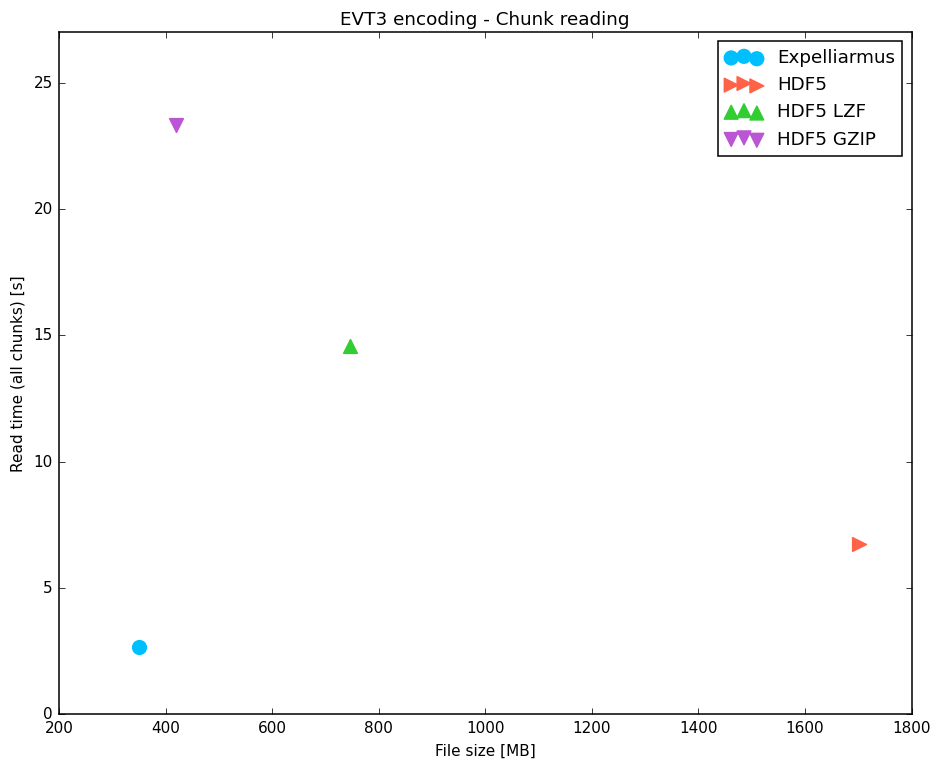

In [13]:
plt.figure(figsize=(10, 8), dpi=110)
plt.ylim(bottom=0, top=27)
plt.xlabel("File size [MB]")
plt.ylabel("Read time (all chunks) [s]")
plt.title("EVT3 encoding - Chunk reading")

# Expelliarmus
exp = plt.scatter(
    data["expelliarmus"]["evt3"]["fsize"],
    data["expelliarmus"]["evt3"]["chunk_read"],
    marker="o",
    s=80,
    color="deepskyblue",
)

# HDF5
hdf5 = plt.scatter(
    data["hdf5"]["evt3"]["fsize"],
    data["hdf5"]["evt3"]["chunk_read"],
    marker=">",
    s=80,
    color="tomato",
)

# HDF5 LZF
hdf5_lzf = plt.scatter(
    data["hdf5_lzf"]["evt3"]["fsize"],
    data["hdf5_lzf"]["evt3"]["chunk_read"],
    marker="^",
    s=80,
    color="limegreen",
)

# HDF5 GZIP
hdf5_gzip = plt.scatter(
    data["hdf5_gzip"]["evt3"]["fsize"],
    data["hdf5_gzip"]["evt3"]["chunk_read"],
    marker="v",
    s=80,
    color="mediumorchid",
)

plt.legend(
    (exp, hdf5, hdf5_lzf, hdf5_gzip),
    ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP"),
    loc="upper right",
)
plt.show()